```
This software is part of GPU Ocean. 

Copyright (C) 2024 SINTEF Digital

Exploring the hourly residuals between NorKyst800 and GPU Ocean in the
simplified model state space. Intended for generating training data for 
learning a stochastic model error.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Looking at the hourly residual between NorKyst800 and GPU Ocean

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from netCDF4 import Dataset
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'

from importlib import reload

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization


In [3]:
%cuda_context_handler gpu_ctx

### Load data and define case

In [4]:
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

casename = 'lofoten'

case_info = NetCDFInitialization.getCaseLocation(casename)
print(case_info["name"])

N = 6

data_args = [None]*N

for i in range(N):
    
    timestep_indices = [[i, i+1]]
    if i == N-1:
        timestep_indices = [[i]]
    
    print(timestep_indices)


    data_args[i] = NetCDFInitialization.getInitialConditions(source_url,
                                                        case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], 
                                                        timestep_indices=timestep_indices,
                                                        download_data=False,
                                                        erode_land=1
                                                        )

lofoten
[[0, 1]]
[[1, 2]]
[[2, 3]]
[[3, 4]]
[[4, 5]]
[[5]]


In [5]:
# Make sims and run for 1 hour:
sims = [None]*(N-1)
for i in range(N-1):
    print("Simulating from hour " + str(i))
    sims[i] = CDKLM16.CDKLM16(gpu_ctx, dt=0,  write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args[i]))
    sims[i].step(3600)


Simulating from hour 0


C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:220: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Simulating from hour 1


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Simulating from hour 2


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Simulating from hour 3


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Simulating from hour 4


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [6]:
def get_residual(sims, data_args, i, subdomain=None):
    eta, hu, hv = sims[i].download(interior_domain_only = True)
    nk_eta =  data_args[i+1]["eta0"][2:-2, 2:-2]
    nk_hu  =  data_args[i+1]["hu0"][ 2:-2, 2:-2]
    nk_hv  =  data_args[i+1]["hv0"][ 2:-2, 2:-2]

    deta = nk_eta - eta
    dhu  = nk_hu  - hu
    dhv  = nk_hv  - hv

    if subdomain:
        # subdomain = [x0, x1, y0, y1]
        deta = deta[subdomain[2]:subdomain[3], subdomain[0]:subdomain[1]]
        dhu  =  dhu[subdomain[2]:subdomain[3], subdomain[0]:subdomain[1]]
        dhv  =  dhv[subdomain[2]:subdomain[3], subdomain[0]:subdomain[1]]

    return deta, dhu, dhv

def get_diff_init(data_args, i):
    deta =  data_args[i+1]["eta0"][2:-2, 2:-2] - data_args[i]["eta0"][2:-2, 2:-2]
    dhu  =  data_args[i+1]["hu0"][ 2:-2, 2:-2] - data_args[i]["hu0"][ 2:-2, 2:-2]
    dhv  =  data_args[i+1]["hv0"][ 2:-2, 2:-2] - data_args[i]["hv0"][ 2:-2, 2:-2]

    return deta, dhu, dhv

def get_diff_sim(sims, i):
    eta0, hu0, hv0 = sims[i].download(interior_domain_only=True)
    eta1, hu1, hv1 = sims[i+1].download(interior_domain_only=True)

    return eta1-eta0, hu1-hu0, hv1-hv0

def plot_residual(deta, dhu, dhv):
    fig = plt.figure(figsize = (18, 3))
    data = [deta, dhu, dhv]

    max_eta = np.max(np.abs(deta))
    max_huv = max(np.max(np.abs(dhv)), np.max(np.abs(dhu)))
    max_vals = [max_eta, max_huv, max_huv]



    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        sp = ax.imshow(data[i], interpolation="none", origin="lower", cmap=plt.cm.coolwarm,
                       vmin=-max_vals[i], vmax=max_vals[i])
        plt.colorbar(sp, shrink=0.9)



Text(0.5, 0.98, 'Init at t = 5')

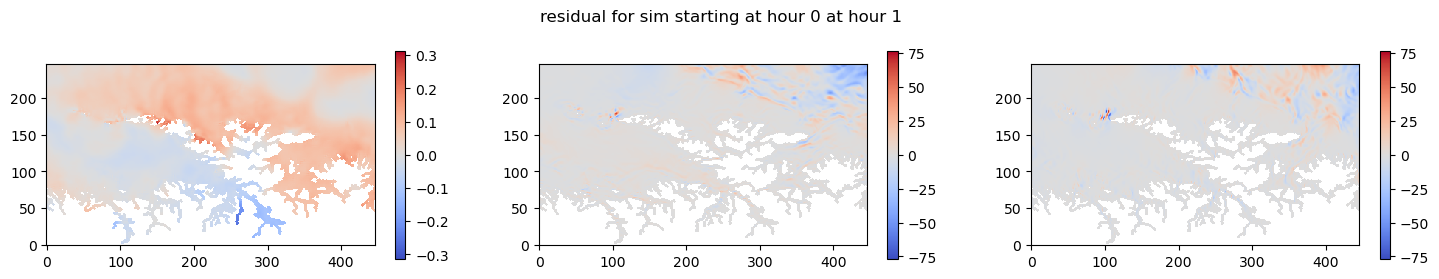

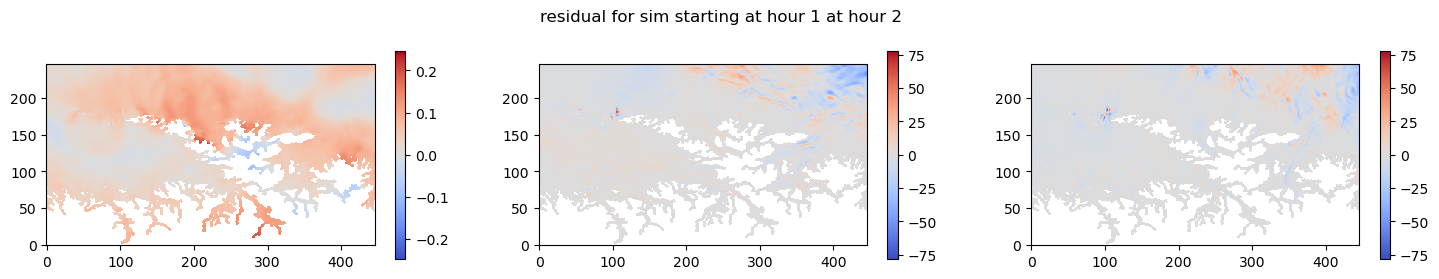

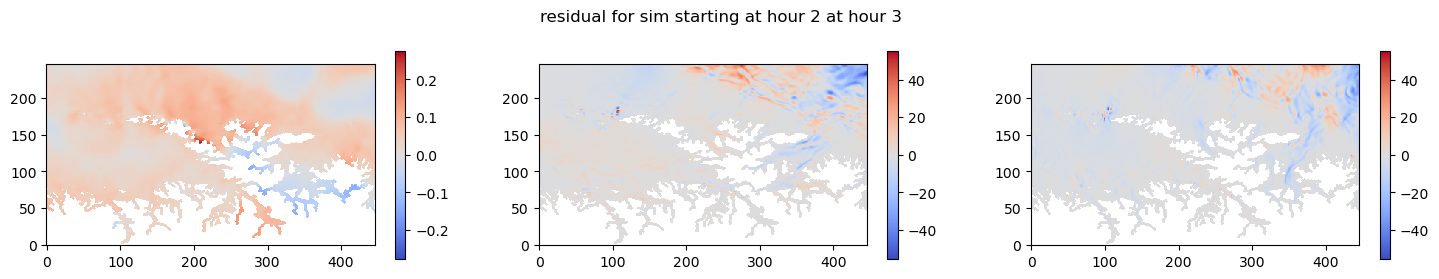

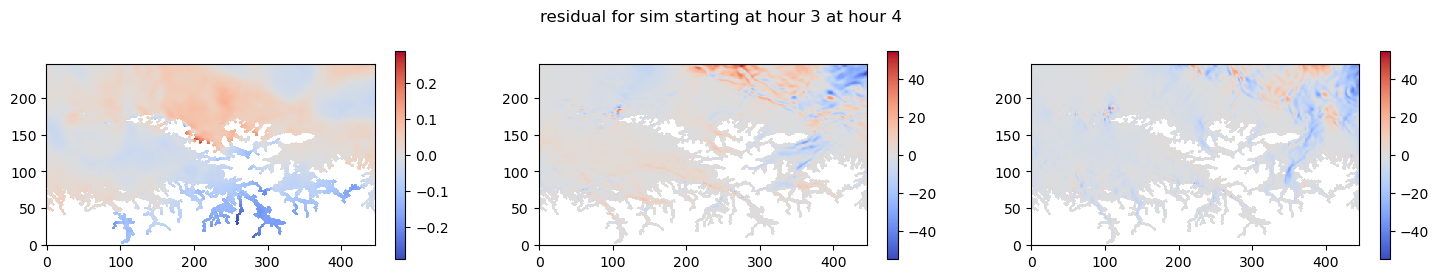

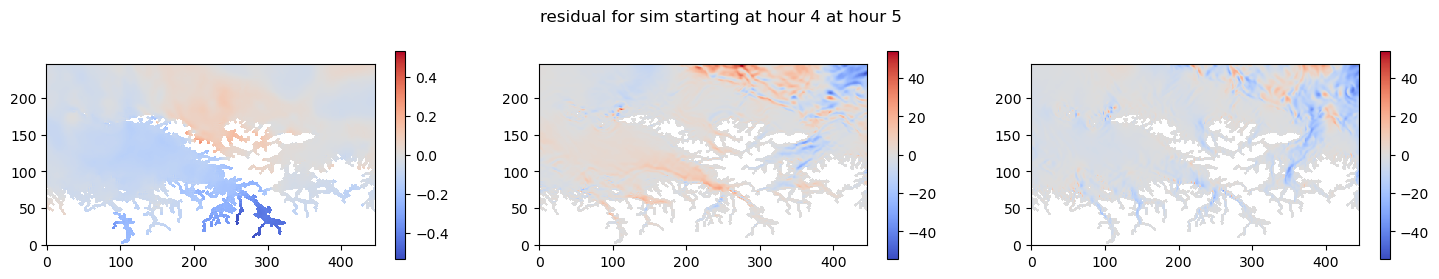

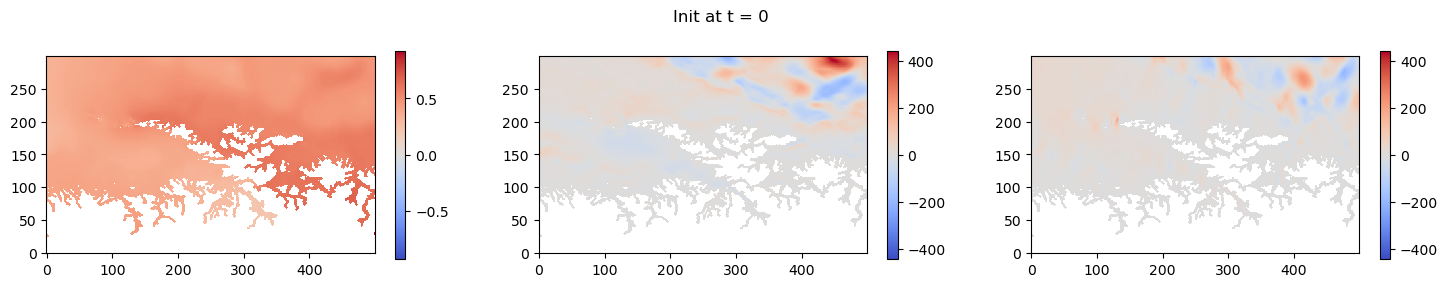

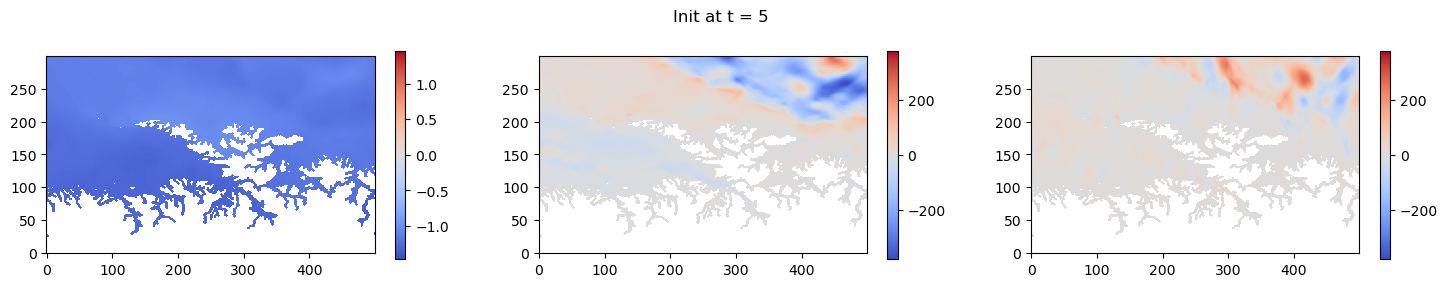

In [7]:
# Residuals:
for i in range(N-1):
    deta, dhu, dhv = get_residual(sims, data_args, i, subdomain=[25,-25, 25,-25])
    plot_residual(deta, dhu, dhv)
    plt.suptitle("residual for sim starting at hour "+ str(i) + " at hour "+ str(i+1))

plot_residual(data_args[0]['eta0'], data_args[0]['hu0'], data_args[0]['hv0'])
plt.suptitle("Init at t = 0")
plot_residual(data_args[N-1]['eta0'], data_args[N-1]['hu0'], data_args[N-1]['hv0'])
plt.suptitle("Init at t = "+str(N-1))

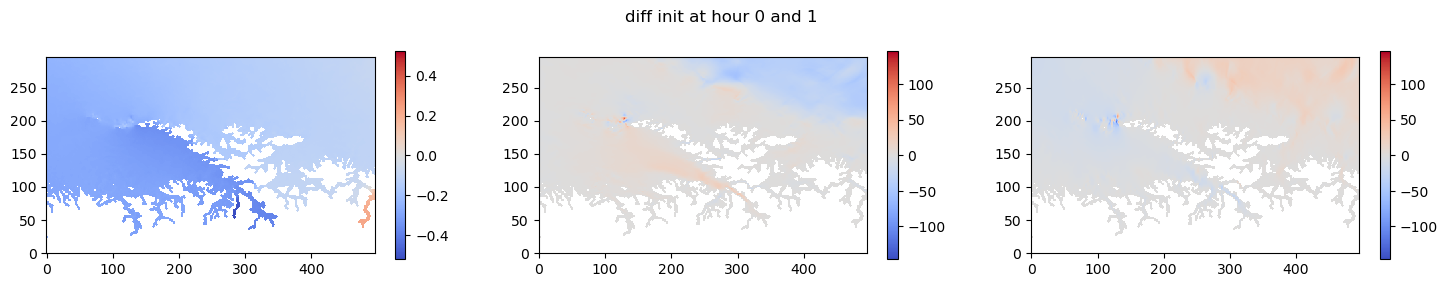

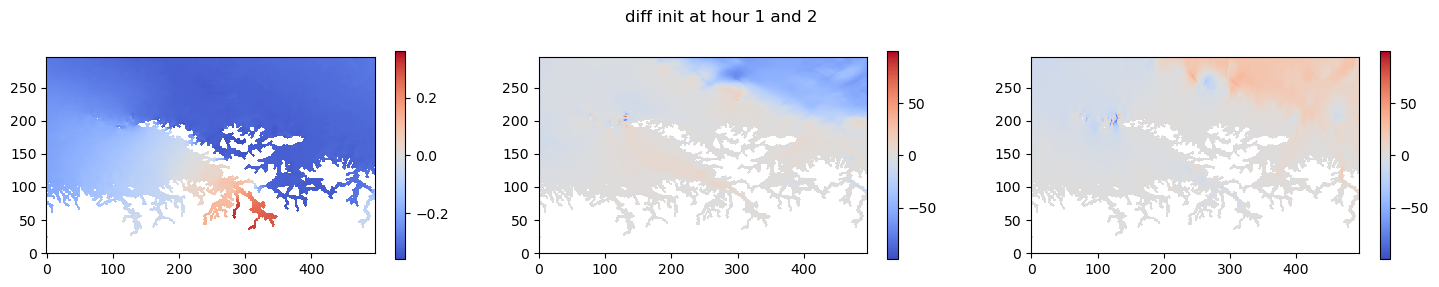

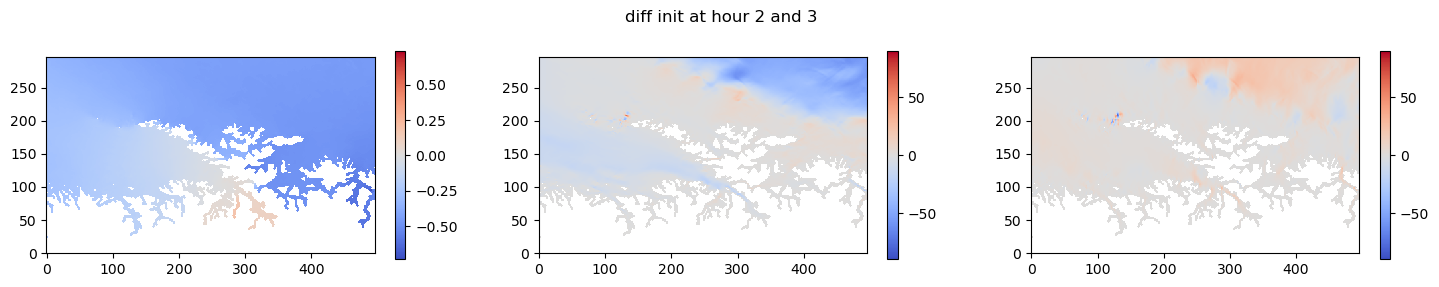

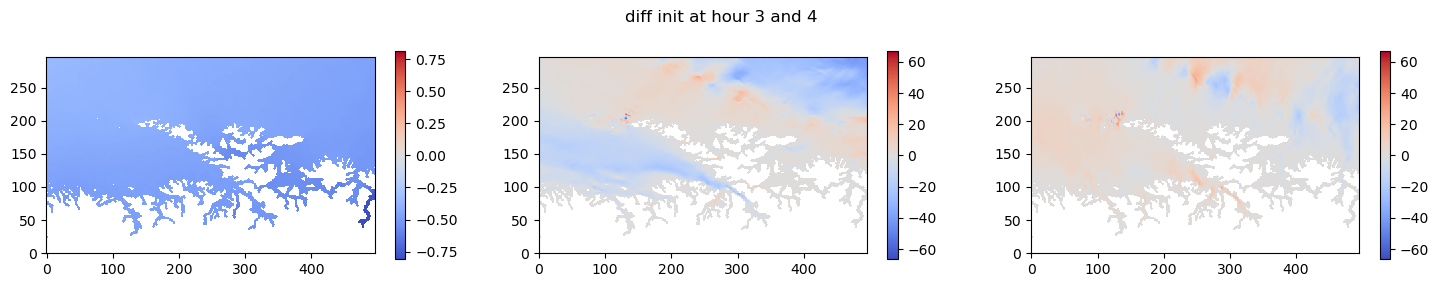

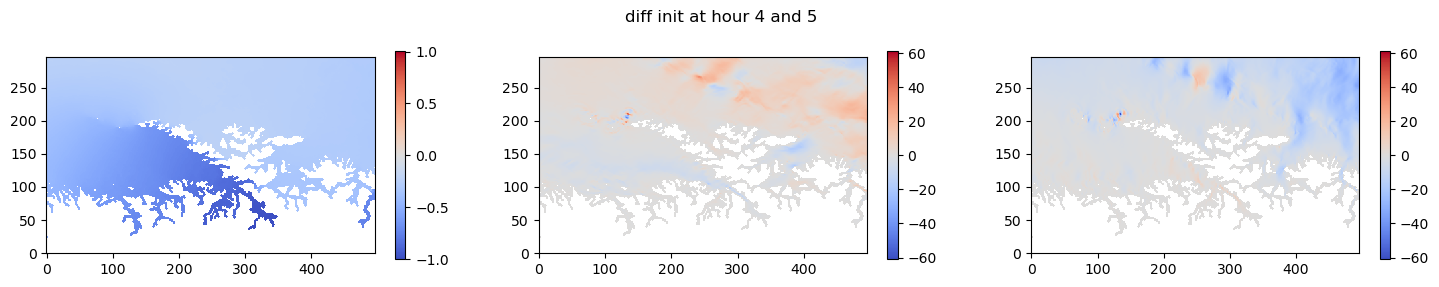

In [16]:
# Differences in initial states:

for i in range(N-1):
    deta, dhu, dhv = get_diff_init(data_args, i)
    plot_residual(deta, dhu, dhv)
    plt.suptitle("diff init at hour "+str(i) + " and "+str(i+1))


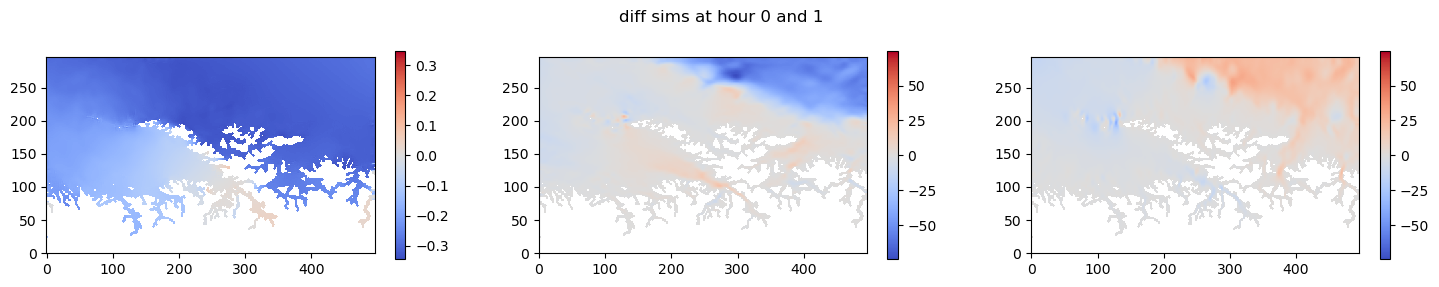

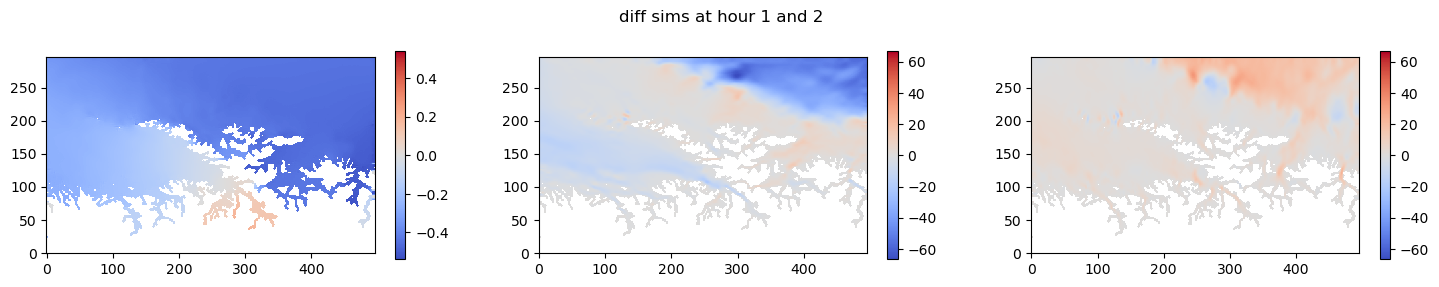

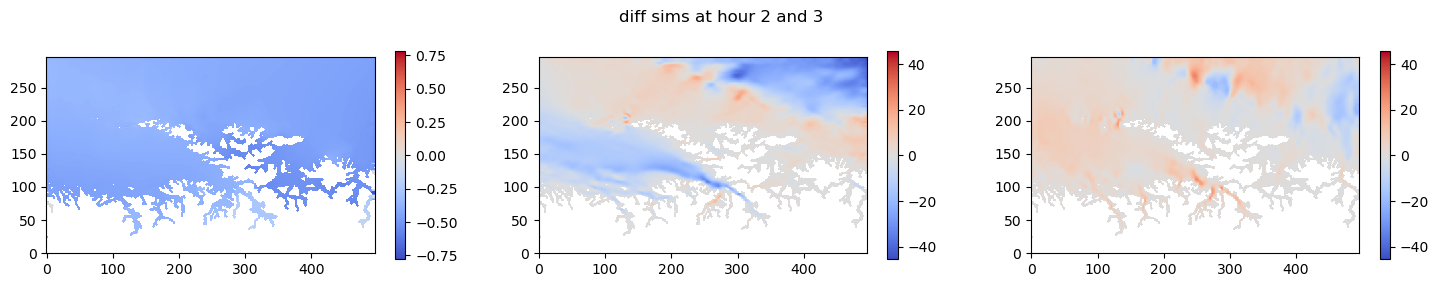

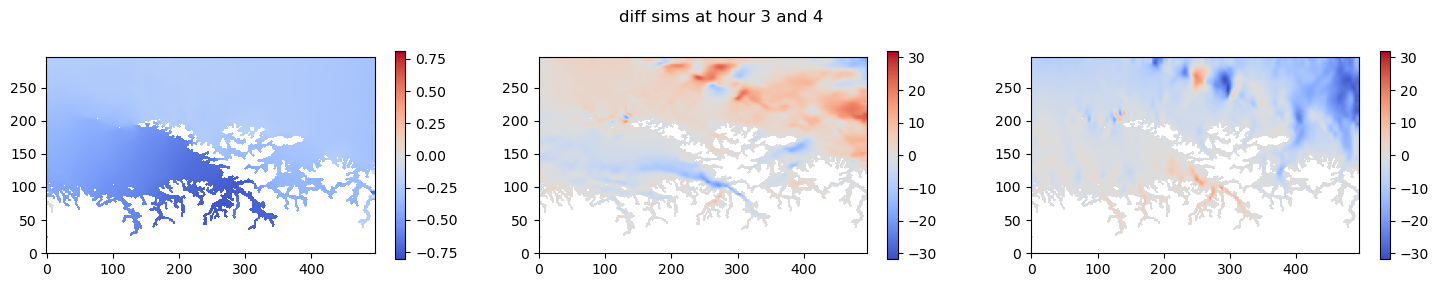

In [9]:
# Differences in simulated states
for i in range(N-2):
    deta, dhu, dhv = get_diff_sim(sims, i)
    plot_residual(deta, dhu, dhv)
    plt.suptitle("diff sims at hour "+str(i) + " and "+str(i+1))



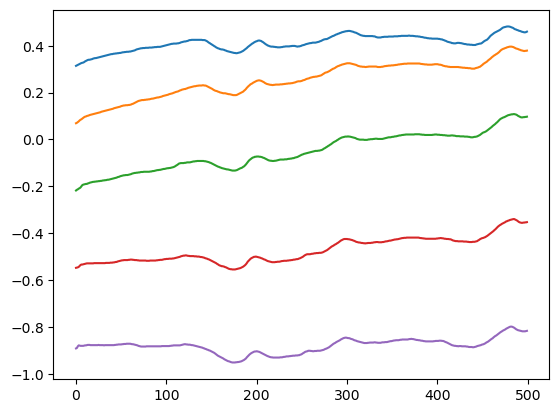

In [10]:
for i in range(N-1):
    plt.plot(data_args[i]['boundary_conditions_data'].north.h[0,:])


In [11]:
data_args[i]['wind'].wind_u.shape

(2, 300, 500)

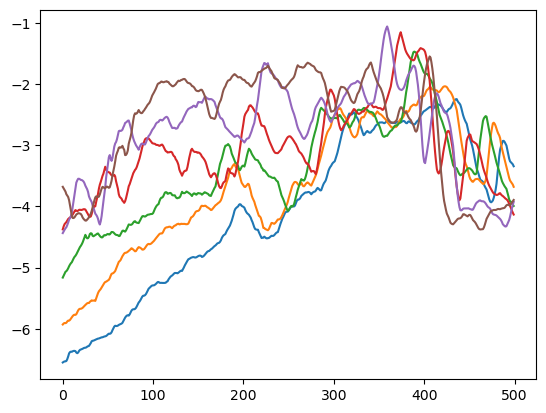

In [12]:
for i in range(N):
    plt.plot(data_args[i]['wind'].wind_u[0][-50, :])

In [13]:
timestep_indices

[[5]]

In [14]:
reload(NetCDFInitialization)
data_args_dummy = NetCDFInitialization.getInitialConditions(source_url,
                                                    case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], 
                                                    timestep_indices=[5, 6, 7],
                                                    download_data=False,
                                                    )
data_args_dummy["boundary_conditions"].getSponge()


{'north': 20, 'south': 20, 'east': 20, 'west': 20}

In [15]:
# def test_instability_filtering():
#     sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args[2]))
#     eta_init, hu_init, hv_init = sim.download()
#     sim.step(5*60)
#     eta5, hu5, hv5 = sim.download()
#     deta5, 

# test_instability_filtering()